# Introduction
I wanted to see if I could answer the following questions I have thought about using Airbnb:
* When to rent to maximise revenue, and for maintenance during off-peak?
* Common group size of Seattle travelers, is it 2 or family or 4 or larger?
* Bedroom configurations to maximise booking rates?
* Main factors to achieve good rating?
* Does higher ratings hosts has higher revenue?
* Common amenities to include?

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Fetching/Preparing Data
Fetch listing and reviews data from csv files, and perform data cleaning
* `review_score_xx` that are empty are assumed that they do not have reviews, so set as zero
* bathrooms, bedrooms, and beds that are empty are assumed that they do not have, so set as zero
* price has dollar sign, remove it and cast as float
* covert date to pandas datatime type

In [2]:
# Load data from listings.csv
# get listings data
pd_listings = pd.read_csv("C:/Users/lukas/Desktop/Programming/austin airbnb/listings.csv")

# select relevant columns from pd_listings
pd_listings = pd_listings[['id','name','neighbourhood','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','amenities','price','guests_included','minimum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]

# basic data cleaning
pd_listings['price'] = pd_listings['price'].str.replace("[$, ]", "").astype("float")

pd_listings.at[pd_listings['bathrooms'].isnull(), 'bathrooms'] = 0
pd_listings.at[pd_listings['bedrooms'].isnull(), 'bedrooms'] = 0 # yea there are 6 that has no bedrooms, but they do have 1 bathrooms
pd_listings.at[pd_listings['beds'].isnull(), 'beds'] = 0 # there's one listing for 1 guest, without any beds

pd_listings.at[pd_listings['review_scores_rating'].isnull(), 'review_scores_rating'] = 0
pd_listings.at[pd_listings['review_scores_accuracy'].isnull(), 'review_scores_accuracy'] = 0
pd_listings.at[pd_listings['review_scores_cleanliness'].isnull(), 'review_scores_cleanliness'] = 0
pd_listings.at[pd_listings['review_scores_checkin'].isnull(), 'review_scores_checkin'] = 0
pd_listings.at[pd_listings['review_scores_communication'].isnull(), 'review_scores_communication'] = 0
pd_listings.at[pd_listings['review_scores_location'].isnull(), 'review_scores_location'] = 0
pd_listings.at[pd_listings['review_scores_value'].isnull(), 'review_scores_value'] = 0

pd_listings.rename(columns={'id':'listing_id'}, inplace=True)
pd_listings.describe().to_csv('austin_airbnb-pd_listings.describe.csv')

C:\Users\lukas\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Load data from reviews.csv
pd_reviews = pd.read_csv("C:/Users/lukas/Desktop/Programming/austin airbnb/reviews.csv")

pd_reviews = pd_reviews[['id','listing_id','date']]

# basic conversions
pd_reviews['date'] = pd.to_datetime(pd_reviews['date'])

pd_reviews.head()

,id,listing_id,date
0,963,2265,2009-03-17
1,1057,2265,2009-03-22
2,200418,2265,2011-03-16
3,1001630,2265,2012-03-15
4,1016390,2265,2012-03-19


## Create bookings DataFrame
In `listings.csv`, it has `number_of_reviews` column, so just to check if number of reviews in `reviews.csv` is equal to `SUM(number_of_reviews)`. Result shows empty result (0 rows), means that the number of reviews in `reviews.csv` matches the sum of number_of_reviews in `listings.csv`.

In [4]:
pd_listing_count_reviews = pd_reviews[['listing_id','id']].groupby(['listing_id']).count()
pd_listing_count_reviews.columns = ['# of reviews']
pd_listing_count_reviews['listing_id'] = pd_listing_count_reviews.index

pd_listings_plus_reviews = pd.merge(pd_listings, pd_listing_count_reviews, on='listing_id')

pd_listings_plus_reviews.at[pd_listings_plus_reviews['# of reviews'].isnull(), '# of reviews'] = 0

pd_listings_plus_reviews[ pd_listings_plus_reviews['# of reviews'] != pd_listings_plus_reviews['number_of_reviews']]

,listing_id,name,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,# of reviews


With this, I shall create a dataframe `pd_bookings` using each review as one booking, and estimate revenue by (`price*minimum_nights`).

In [5]:
# Calculate estimated revenue for each listing

# get estimated bookings base on reviews
pd_bookings = pd.merge(pd_reviews, pd_listings, on='listing_id')
pd_bookings['estimated_revenue'] = pd_bookings['price'] * pd_bookings['minimum_nights']

# get revenue by listings
pd_listings_revenue = pd_bookings[['listing_id','estimated_revenue']].groupby(['listing_id']).sum()
pd_listings_revenue['listing_id'] = pd_listings_revenue.index

pd_listings = pd.merge(pd_listings, pd_listings_revenue, on='listing_id', how='left')
pd_listings.at[pd_listings['estimated_revenue'].isnull(), 'estimated_revenue'] = 0
pd_listings.head().to_csv('austin_airbnb-pd_listings.head-2.csv')

# Analysis Time

In [6]:
# Show 5 highest revenue listings
pd_listings[['listing_id','number_of_reviews','minimum_nights','accommodates','bedrooms','beds','estimated_revenue']].sort_values('estimated_revenue', ascending=False).head().to_csv('austin_airbnb-pd_listings-5-toplistings.csv ')

Wow! Looks like our top earners are hosts have minimum nights of 360. Let's look at the proportion of listings with different `minimum_nights`.

In [7]:
pd_listings[['listing_id','minimum_nights']].groupby(['minimum_nights']).count()

,listing_id
minimum_nights,
1,4050
2,4061
3,1263
4,237
5,184
6,32
7,128
8,3
9,4


Most hosts have `minimum_nights` of up to a month, the host with 500 nights, gotta filter it away.

In [8]:
# Showing 5 highest revenue listings (minimum_nights <= 30)
pd_listings.loc[pd_listings['minimum_nights']<=30, ['listing_id','number_of_reviews','minimum_nights','accommodates',
                                                   'bedrooms','beds','estimated_revenue']].sort_values('estimated_revenue',
                                                                                                       ascending=False).head()

,listing_id,number_of_reviews,minimum_nights,accommodates,bedrooms,beds,estimated_revenue
886,2665394,107,20,10,4.0,7.0,1682040.0
696,2248559,144,30,8,4.0,6.0,1464480.0
3610,17209248,111,30,2,0.0,2.0,1332000.0
317,751847,128,30,8,4.0,5.0,1148160.0
62,89475,116,30,8,4.0,6.0,1144920.0


In [9]:
# Showing 5 highest revenue listings (minimum_nights <= 1)
pd_listings.loc[pd_listings['minimum_nights']<=1, ['listing_id','number_of_reviews','minimum_nights','accommodates',
                                                   'bedrooms','beds','estimated_revenue']].sort_values('estimated_revenue',
                                                                                                       ascending=False).head()

,listing_id,number_of_reviews,minimum_nights,accommodates,bedrooms,beds,estimated_revenue
7136,31742478,92,1,4,1.0,2.0,920000.0
7272,32208003,79,1,4,1.0,2.0,790000.0
7137,31746889,76,1,4,1.0,2.0,760000.0
7255,32162852,76,1,4,1.0,2.0,760000.0
7925,34569032,74,1,4,1.0,2.0,740000.0


It looks like short term hosts has lower revenue compared to our long term hosts. What is the correlation between minimum nights and estimated revenue?

In [29]:
# Correlation between minimum nights and estimated revenue (not filtering min night 1000)
pd_listings[['minimum_nights','estimated_revenue']].corr()

,minimum_nights,estimated_revenue
minimum_nights,1.000000,0.328653
estimated_revenue,0.328653,1.000000


In [30]:
# Correlation between minimum nights and estimated revenue (filter min night 1000)
pd_listings.loc[pd_listings['minimum_nights']<=30, ['minimum_nights','estimated_revenue']].corr().to_csv('austin_airbnb-minnightsrevenue-remove500nights.csv')

Host with 30 minimum nights has influenced the correlation for revenue. But after removing that host, minimum nights and estimated revenue are not highly correlated.

### Best Months for Rental
It would be useful to know the most popular time of the year to rent in Austin (so dont have to rent all year round and do maintenance during offpeak wont hurt revenue)

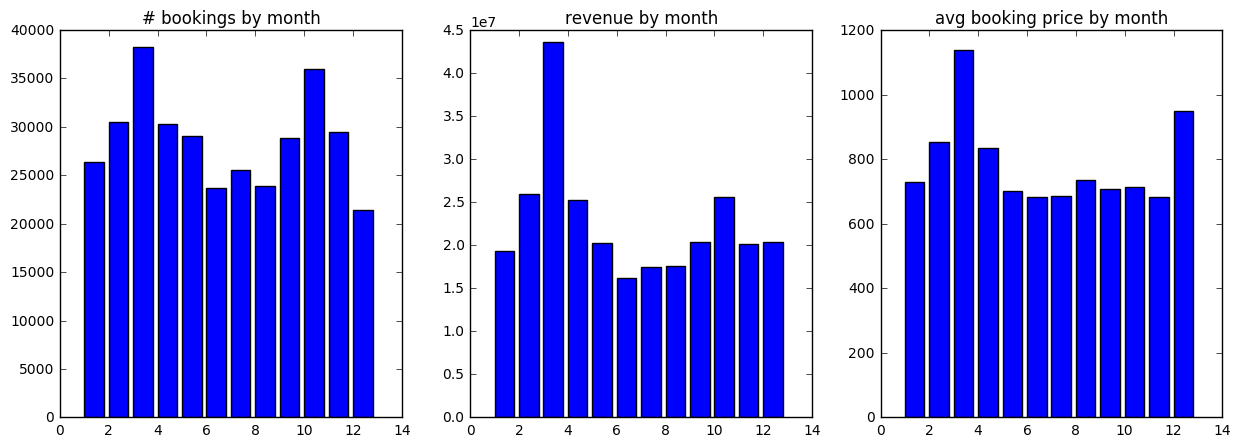

In [12]:
# Best months for rental?

plt.figure(figsize=(15, 5))

# bookings by month
plotdata = pd_reviews[['date']].groupby(pd_reviews["date"].dt.month).count()
plotdata.rename(columns={'date':'# of bookings'}, inplace=True)

ax = plt.subplot(1, 3, 1)
ax.set_title("# bookings by month")
plt.bar(plotdata.index, plotdata['# of bookings'])

# revenue by month
plotdata2 = pd_bookings[['date','estimated_revenue']].groupby(pd_bookings["date"].dt.month).sum()
plotdata2.rename(columns={'estimated_revenue':'revenue'}, inplace=True)

ax = plt.subplot(1, 3, 2)
ax.set_title("revenue by month")
plt.bar(plotdata2.index, plotdata2['revenue'])

# avg booking price by month
plotdata3 = pd.concat([plotdata, plotdata2], axis=1)
plotdata3['avg booking price'] = plotdata3['revenue'] / plotdata3['# of bookings']
plotdata3.head()

ax = plt.subplot(1, 3, 3)
ax.set_title("avg booking price by month")
plt.bar(plotdata3.index, plotdata3['avg booking price'])

_ = plt.plot()

It looks like March is the best date to rent (SXSW), with October following close behind (ACL). The best time for maitenence work looks like June-August. 

Dive into the price, what are the range, and where are the expensive listings? To normalise price to compare between listings, we usually look at per person per night. That's what we usually do when we travel.

In [13]:
pd_listings['price_per_person_per_night'] = pd_listings['price'] / pd_listings['accommodates'] / pd_listings['minimum_nights']

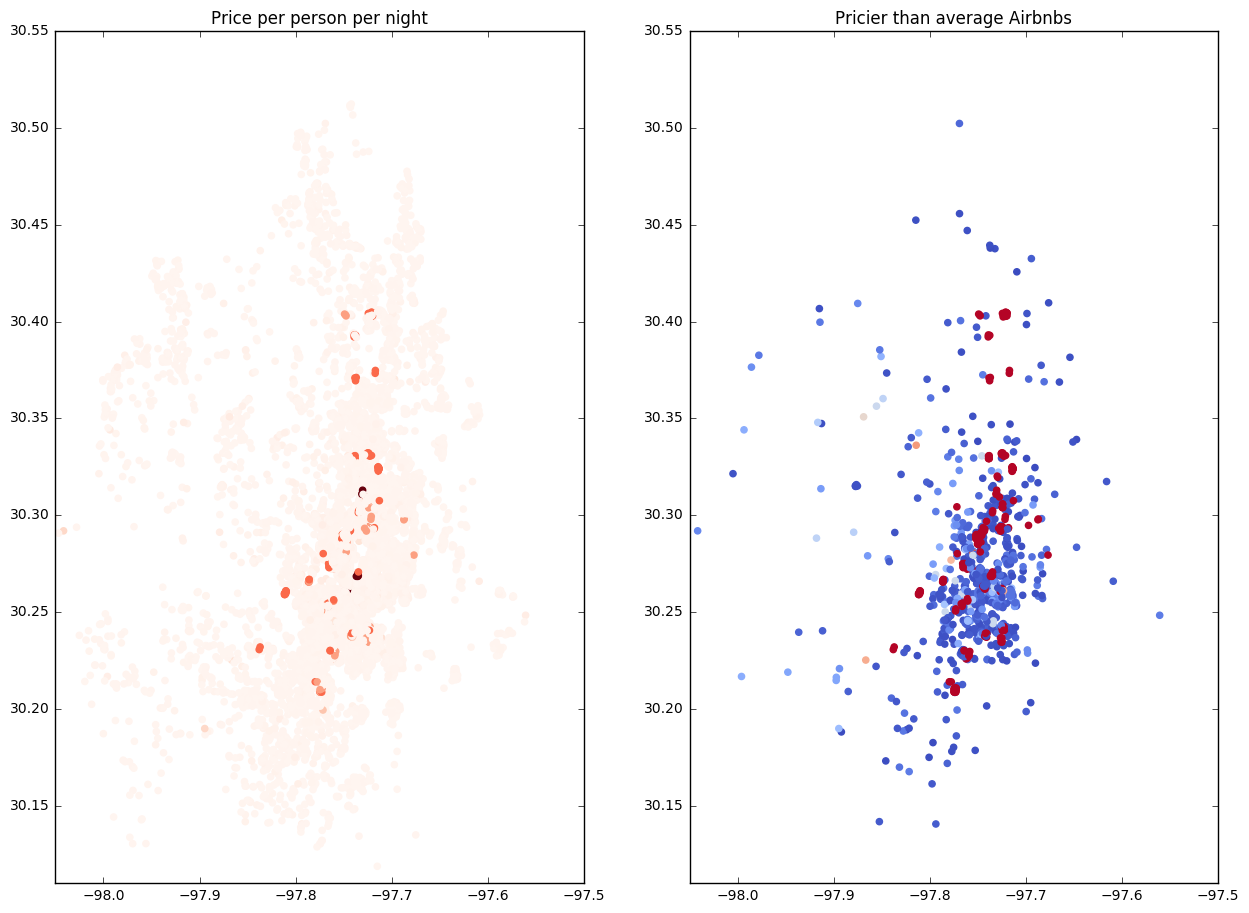

In [14]:
# Pricier than average Airbnbs
filter_price_gt = 75

plt.figure(figsize=(15, 11))

ax = plt.subplot(1, 2, 1)
ax.set_title("Price per person per night")

ax.set_autoscaley_on(False)
ax.set_ylim([30.11, 30.55])
ax.set_autoscalex_on(False)
ax.set_xlim([-98.05, -97.5])
plt.scatter(pd_listings["longitude"],
            pd_listings["latitude"],
            cmap="Reds",
            edgecolor='face',
            c=pd_listings["price_per_person_per_night"] / pd_listings["price_per_person_per_night"].max())


ax = plt.subplot(1, 2, 2)
ax.set_title("Pricier than average Airbnbs")

ax.set_autoscaley_on(False)
ax.set_ylim([30.11, 30.55])
ax.set_autoscalex_on(False)
ax.set_xlim([-98.05, -97.5])
plt.scatter(pd_listings[pd_listings['price_per_person_per_night'] > filter_price_gt]["longitude"],
            pd_listings[pd_listings['price_per_person_per_night'] > filter_price_gt]["latitude"],
            cmap="coolwarm",
            edgecolor='face',
            c=pd_listings[pd_listings['price_per_person_per_night'] > filter_price_gt]["price"] / pd_listings[pd_listings['price_per_person_per_night'] > filter_price_gt]["price"].max())

_ = plt.plot()

Pricy listings are quite scattered, though we see a cluster of them at the middle.

How about which neighbourhood has the highest revenue?

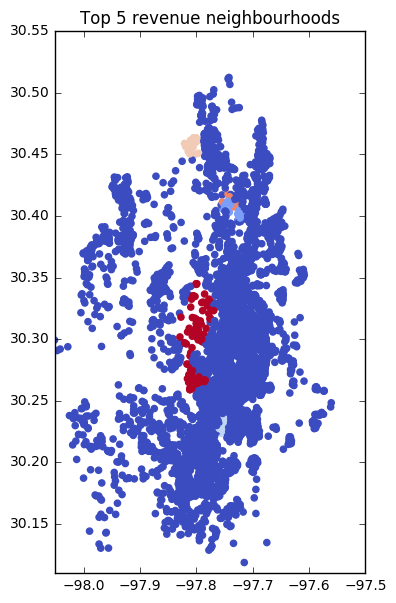

In [15]:
# Revenue by neighbourhood

pd_neighbourhood_revenue = pd_listings[['neighbourhood','estimated_revenue']].groupby(['neighbourhood']).mean().sort_values('estimated_revenue', ascending=False)
pd_neighbourhood_revenue.to_csv('austin_airbnb-toplisting-neighbourhood.csv')

pd_listings_plot = pd_listings[['neighbourhood','longitude','latitude','estimated_revenue']]
pd_listings_plot.loc[:,'color'] = 0

color_value = 1
for neighbourhood in pd_neighbourhood_revenue[0:5].index:
  pd_listings_plot.at[pd_listings_plot['neighbourhood'] == neighbourhood, 'color'] = color_value
  color_value -= 0.2

# plot
plt.figure(figsize=(4, 7))
ax = plt.subplot(1, 1, 1)
ax.set_title("Top 5 revenue neighbourhoods")

ax.set_autoscaley_on(False)
ax.set_ylim([30.11, 30.55])
ax.set_autoscalex_on(False)
ax.set_xlim([-98.05, -97.5])
plt.scatter(pd_listings_plot['longitude'],
            pd_listings_plot['latitude'],
            cmap="coolwarm",
            edgecolor='face',
            c=pd_listings_plot['color']
           )

_ = plt.plot()

It's clear that Westlake Hills, Mesa Park, and Anderson Mill are the highest revenue neighbourhoods. From Google Maps, Westlake Hills is very close to Zilker Park, home to ACL every year.

What are the common group size? is it 2? or family of 4? or larger? And if guest usually comes in 2s, is it over saturated? (supply and demand)

In [40]:
# Guests’ group size, and supply & demand

def get_supply_demand_by(by_column_name, pd_listings, pd_bookings):
    # get supply: number of listing that provide X 
    pd_listing_supply_by_pax = pd_listings[[by_column_name,'listing_id']].groupby([by_column_name]).count().sort_values('listing_id', ascending=False)
    pd_listing_supply_by_pax.rename(columns={'listing_id':'# of listings'}, inplace=True)

    # get demand base on bookings
    pd_listing_demand_by_pax = pd_bookings[[by_column_name,'id']].groupby([by_column_name]).count().sort_values('id', ascending=False)
    pd_listing_demand_by_pax.rename(columns={'id':'# of bookings'}, inplace=True)

    # merge supply and demand
    pd_listing_supply_demand_pax = pd.concat([pd_listing_supply_by_pax, pd_listing_demand_by_pax], axis=1)
    pd_listing_supply_demand_pax['ratio'] = pd_listing_supply_demand_pax['# of bookings'] / pd_listing_supply_demand_pax['# of listings']

    pd_listing_supply_demand_pax = pd_listing_supply_demand_pax.sort_values('ratio', ascending=False)

    return pd_listing_supply_demand_pax

get_supply_demand_by('accommodates', pd_listings, pd_bookings)

,# of listings,# of bookings,ratio
accommodates,,,
3,905,38780.0,42.850829
17,1,37.0,37.000000
11,38,1397.0,36.763158
16,245,8824.0,36.016327
12,168,5997.0,35.696429
2,3107,108472.0,34.912134
14,76,2412.0,31.736842
10,401,12069.0,30.097257
9,95,2795.0,29.421053


A place for 3 ranked first, with the demand is considered high (>38,000 bookings) as compared to places for 1 or 2 person.

Renting a place for 2 or 3 person will give host a pretty good regular rentals.

Do these guests prefer 1 bedroom or 2 separate bedrooms?

In [42]:
# Bedrooms configurations for 2 person
get_supply_demand_by('bedrooms', pd_listings[pd_listings['accommodates']<=2], pd_bookings[pd_bookings['accommodates']<=2])

,# of listings,# of bookings,ratio
bedrooms,,,
0.0,364,18475.0,50.755495
1.0,3124,95864.0,30.686300
2.0,68,1310.0,19.264706
3.0,2,5.0,2.500000
4.0,1,1.0,1.000000
5.0,1,NaN,NaN


In [44]:
# Bedrooms configurations for 3 person
get_supply_demand_by('bedrooms', pd_listings[pd_listings['accommodates']==3], pd_bookings[pd_bookings['accommodates']==3])

,# of listings,# of bookings,ratio
bedrooms,,,
0.0,117,8411,71.888889
1.0,705,28592,40.556028
2.0,76,1738,22.868421
3.0,7,39,5.571429


Majority prefers 0 bed rooms, less than 1% prefers 2 bedrooms (1310 out of 18475). But wait, 0 bedrooms, what are kind of apartments are these?

In [34]:
# Places with 0 bedrooms
pd_listings[pd_listings['bedrooms']==0][['room_type','listing_id']].groupby(['room_type']).count().sort_values('listing_id', ascending=False)

,listing_id
room_type,
Entire home/apt,625
Private room,50
Hotel room,2


All these 0 bedrooms apartments are renting their entire home, so we can assume these have 1 room. Let's hope they provide beds?

In [36]:
# Number of beds in 0 bedrooms apartments
pd_bed_count = pd_listings[pd_listings['bedrooms']==0][['beds','listing_id']].groupby(['beds']).count().sort_values('listing_id', ascending=False)
pd_bed_count.rename(columns={'listing_id':'# of listings'}, inplace=True)
pd_bed_count

,# of listings
beds,
1.0,395
2.0,221
0.0,30
3.0,19
4.0,8
16.0,2
5.0,1
6.0,1


At least 1 bed are provided in these 0 bedrooms apartments

In [21]:
# Popular bed configurations
pd_bed_count = pd_listings[['beds','listing_id']].groupby(['beds']).count().sort_values('listing_id', ascending=False)
pd_bed_count.rename(columns={'listing_id':'# of listings'}, inplace=True)
pd_bed_count

,# of listings
beds,
1.0,4235
2.0,2890
3.0,1662
4.0,775
5.0,421
6.0,266
0.0,233
7.0,162
8.0,103


In [32]:
# Bedroom configurations with highest demands?
get_supply_demand_by('bedrooms', pd_listings, pd_bookings)

,# of listings,# of bookings,ratio
bedrooms,,,
13.0,1,111.0,111.000000
0.0,677,34125.0,50.406204
1.0,5298,171728.0,32.413741
2.0,2561,73094.0,28.541195
4.0,675,17994.0,26.657778
3.0,1486,37256.0,25.071332
7.0,29,727.0,25.068966
5.0,236,5781.0,24.495763
6.0,81,1840.0,22.716049


Looks like 1 to 2 bedrooms configuration has most demands, or renting the entire home (zero bedrooms).

Top most correlated columns:
review_scores_accuracy
review_scores_communication
review_scores_cleanliness
review_scores_checkin
review_scores_value
review_scores_location


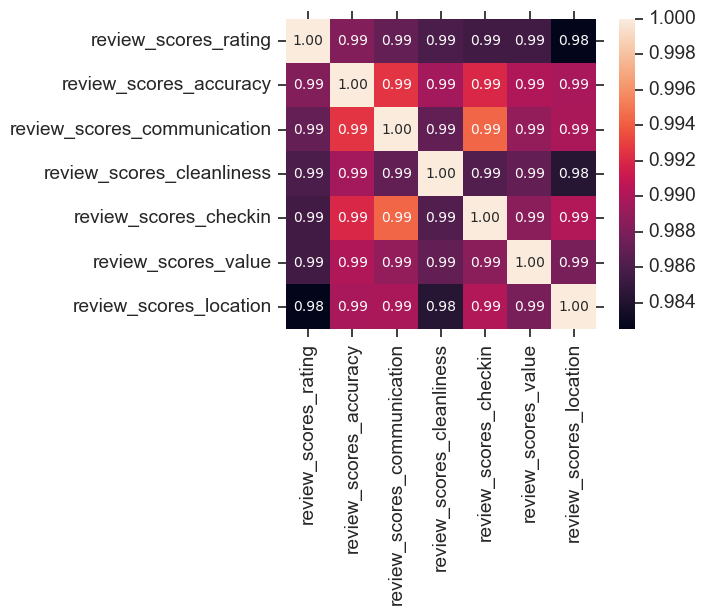

In [23]:
# Which factors (ratings) matters the most to visitors of Austin? 

pd_listings_reviews = pd_listings[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]

def plot_topn_correlation_matrix_with_target(df, target_col_name, k=10):
    corrmat = df.corr()
    top_correlated_columns = corrmat.nlargest(k, target_col_name)[target_col_name].index
    cm = np.corrcoef(df[top_correlated_columns].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': k}, yticklabels=top_correlated_columns.values, xticklabels=top_correlated_columns.values)
  
    return top_correlated_columns.values

top_correlated_columns = plot_topn_correlation_matrix_with_target(pd_listings_reviews, 'review_scores_rating')

print("Top most correlated columns:")
for i in top_correlated_columns:
    if(i!='review_scores_rating'):
        print(i)

Host with good communication is tends to get high overall rating, host in Austin needs to be responsive and friendly. Good communication also directly impacts check-in rating.

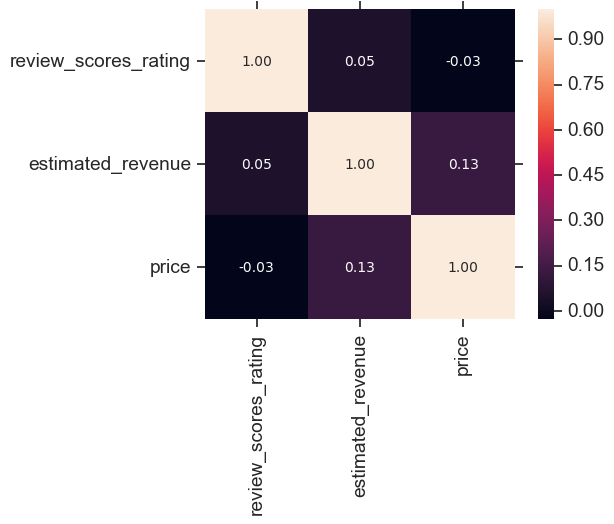

In [24]:
# Does good rating affects price and revenue?

_ = plot_topn_correlation_matrix_with_target(pd_listings[['estimated_revenue','price','review_scores_rating']], 'review_scores_rating')

Good rating has little impact to the price set by the host Good rating also have very small positive correlation with revenue

How about amenities, what other host are providing in their amenities?

In [47]:
# These are top 10 most common amenities
rows_amenities = []
rows_listing_id = []

for id, row in pd_listings.loc[:, ['listing_id','amenities']].iterrows():
    rows_listing_id.append(row['listing_id'])
  
    row_amenities = {}
    amenities = row['amenities'].strip('{}')
    for amenity in amenities.split(','):
        row_amenities[amenity.strip('"')] = 1
    rows_amenities.append(row_amenities)

pd_listings_amenities = pd.DataFrame(rows_amenities, index=rows_listing_id)
pd_listings_amenities = pd_listings_amenities.fillna(0)
pd_listings_amenities.drop('', axis=1, inplace=True)
pd_listings_amenities['listing_id'] = pd_listings_amenities.index
pd_listings_amenities = pd.merge(pd_listings_amenities, pd_listings[['listing_id','number_of_reviews']], on='listing_id')

pd_rows_amenities = pd_listings_amenities.sum(axis=0)

pd_amenities_count = pd.DataFrame({'amenities':pd_rows_amenities.index, 'count':pd_rows_amenities.values})
pd_amenities_count = pd_amenities_count.sort_values('count', ascending=False)[:10]

pd_amenities_count.drop(271, axis=0, inplace=True) # drop listing_id
pd_amenities_count.drop(272, axis=0, inplace=True) # drop number_of_reviews

pd_amenities_count

,amenities,count
4,Air conditioning,10876.0
263,Wifi,10731.0
117,Heating,10634.0
76,Essentials,10355.0
133,Kitchen,10300.0
221,Smoke detector,10242.0
238,TV,9422.0
94,Free parking on premises,9212.0


Air conditioning, WiFi and heating are listed as necessities in Austin.

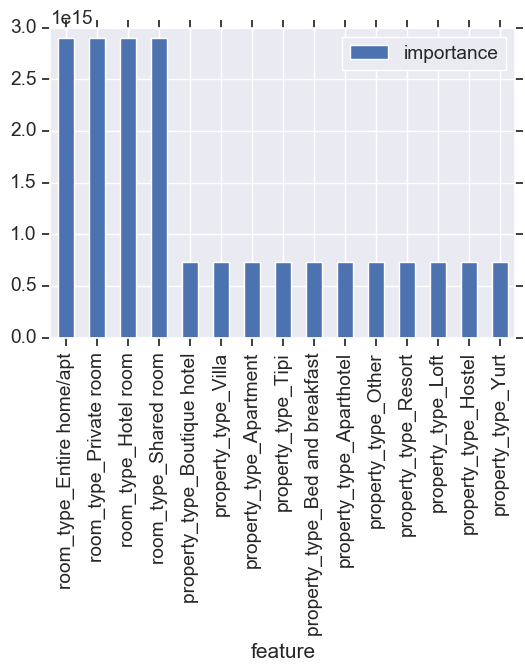

In [26]:
# Features with most weight by Linear Regression

# prep data, normalise, one-hot
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

pd_model_data_x = pd_listings[['neighbourhood','property_type','room_type','accommodates','bathrooms','bedrooms','beds','guests_included']]
pd_model_data_x['accommodates'] = min_max_scaler.fit_transform(pd_model_data_x[['accommodates']])
pd_model_data_x['bathrooms'] = min_max_scaler.fit_transform(pd_model_data_x[['bathrooms']])
pd_model_data_x['bedrooms'] = min_max_scaler.fit_transform(pd_model_data_x[['bedrooms']])
pd_model_data_x['beds'] = min_max_scaler.fit_transform(pd_model_data_x[['beds']])
pd_model_data_x['guests_included'] = min_max_scaler.fit_transform(pd_model_data_x[['guests_included']])

pd_model_data_x = pd.get_dummies(pd_model_data_x, columns=['neighbourhood','property_type','room_type'])
pd_model_data_y = pd_listings['price']

# train and test - x and y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pd_model_data_x,pd_model_data_y,test_size=0.10, random_state=789)

# linear regression
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)

coefficients = pd.DataFrame({'feature': X_train.columns, 'importance': lm.coef_})
_ = coefficients.sort_values('importance', ascending=False)[:15].plot(x='feature', y='importance', kind='bar')

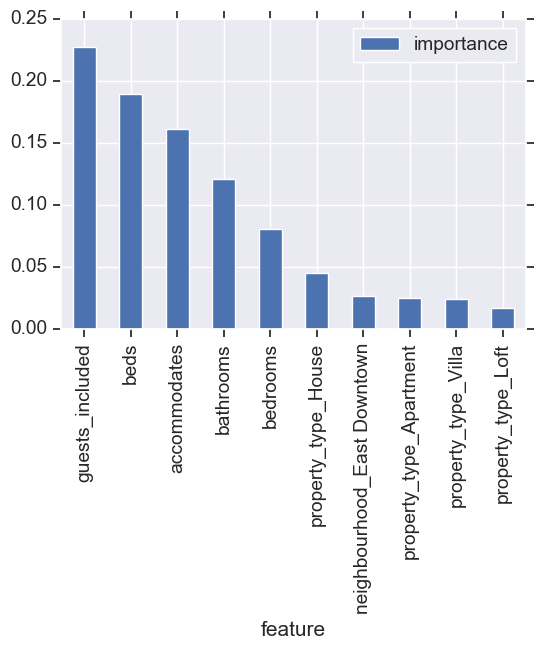

In [27]:
# Features with most weight by Decision Tree

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

# Make the decision tree
dtree = tree.DecisionTreeClassifier(
    class_weight="balanced",
    min_weight_fraction_leaf=0.01,)
dtree = dtree.fit(X_train,y_train)

# Look at outputs
importances = dtree.feature_importances_
feat_names = X_train.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
_ = tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar')